## Bonus Assignment 

On the dataset we used in the lab session (for detecting diabetes), achieve an F1 score above 0.9 (on the test set) using whatever classification method you like (test set should be 20% of the whole data).

**Import libraries**

In [43]:
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

**read dataset**

In [44]:
diabets = pd.read_csv('./diabetes.csv')

## Data Preprocessing

In [45]:
diabets.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


It's good :

We don't have any null values and all columns data is numerical

In [46]:
diabets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**Missing Observation Analysis**

We saw on ```df.head()``` that some features contain 0, it doesn't make sense here and this indicates missing value Below we replace 0 value by NaN:

In [47]:
diabets[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabets[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [48]:
# Now, we can look at where are missing values
diabets.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [49]:
# The missing values will be filled with the median values of each variable.

def median_target(df, var):   
    
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    
    return temp

In [50]:
columns = diabets.columns
columns = columns.drop("Outcome")

In [51]:
# The values to be given for incomplete observations are given the median value of people who are not sick and the median values of people who are sick.
columns = diabets.columns
columns = columns.drop("Outcome")

for col in columns:
    diabets.loc[(diabets['Outcome'] == 0 ) & (diabets[col].isnull()), col] = median_target(diabets, col)[col][0]
    diabets.loc[(diabets['Outcome'] == 1 ) & (diabets[col].isnull()), col] = median_target(diabets, col)[col][1]

In [52]:
diabets.loc[(diabets['Outcome'] == 0 ) & (diabets["Pregnancies"].isnull()), "Pregnancies"]
diabets[(diabets['Outcome'] == 0 ) & (diabets["BloodPressure"].isnull())]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


**Check for Outliers**

Outliers are data points that deviate significantly from the rest of the data in a dataset. They are observations that lie an abnormal distance from other values in a random sample from a population. In other words, outliers are data points that are unusually far from the central tendency of a distribution.

In [53]:
import plotly.express as px

for col in diabets.columns:
    fig = px.box(diabets, y=col)
    fig.update_traces(marker_color='#FF851B')
    fig.update_layout(autosize=False, width=600, height=500, title='Detected Outliers')
    fig.show()


## Feature engineering

Feature Engineering is the process of creating new features or transforming existing features to improve the performance of a machine-learning model. It involves selecting relevant information from raw data and transforming it into a format that can be easily understood by a model. The goal is to improve model accuracy by providing more meaningful and relevant information

In [54]:
# According to BMI, some ranges were determined and categorical variables were assigned.
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

diabets["NewBMI"] = NewBMI

diabets.loc[diabets["BMI"] < 18.5, "NewBMI"] = NewBMI[0]

diabets.loc[(diabets["BMI"] > 18.5) & (diabets["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
diabets.loc[(diabets["BMI"] > 24.9) & (diabets["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
diabets.loc[(diabets["BMI"] > 29.9) & (diabets["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
diabets.loc[(diabets["BMI"] > 34.9) & (diabets["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
diabets.loc[diabets["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

In [55]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"     

In [56]:
diabets["NewInsulinScore"] = diabets.apply(set_insulin, axis=1)

In [57]:
# Some intervals were determined according to the glucose variable and these were assigned categorical variables.
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")

diabets["NewGlucose"] = NewGlucose

diabets.loc[diabets["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]

diabets.loc[(diabets["Glucose"] > 70) & (diabets["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]

diabets.loc[(diabets["Glucose"] > 99) & (diabets["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]

diabets.loc[diabets["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

**One-hot encoding**

In [58]:
diabets = pd.get_dummies(diabets, columns =["NewBMI","NewInsulinScore", "NewGlucose"], drop_first = True)

In [59]:
categorical_df = diabets[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

**Split data (Train & Test) & Feature Scaling**

Assuming ```Outcome``` is the column representing the likelihood of a has diabet

In [60]:
from sklearn.preprocessing import RobustScaler

y = diabets["Outcome"]
X = diabets.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'], axis = 1)

cols = X.columns
index = X.index

transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

X = pd.concat([X, categorical_df], axis = 1)

**Prediction**

We can see we achive ```f1_score``` above than 90% (91 %) with ```Random Forest Classifier```

In [61]:
from sklearn.model_selection import KFold,cross_val_score

Logistic Regression
F1 Score:  0.8224299065420562
********
KNN
F1 Score:  0.8392857142857143
********
Decision Tree
F1 Score:  0.8
********
Random Forest
F1 Score:  0.9174311926605505
********
SVM
F1 Score:  0.8490566037735849
********


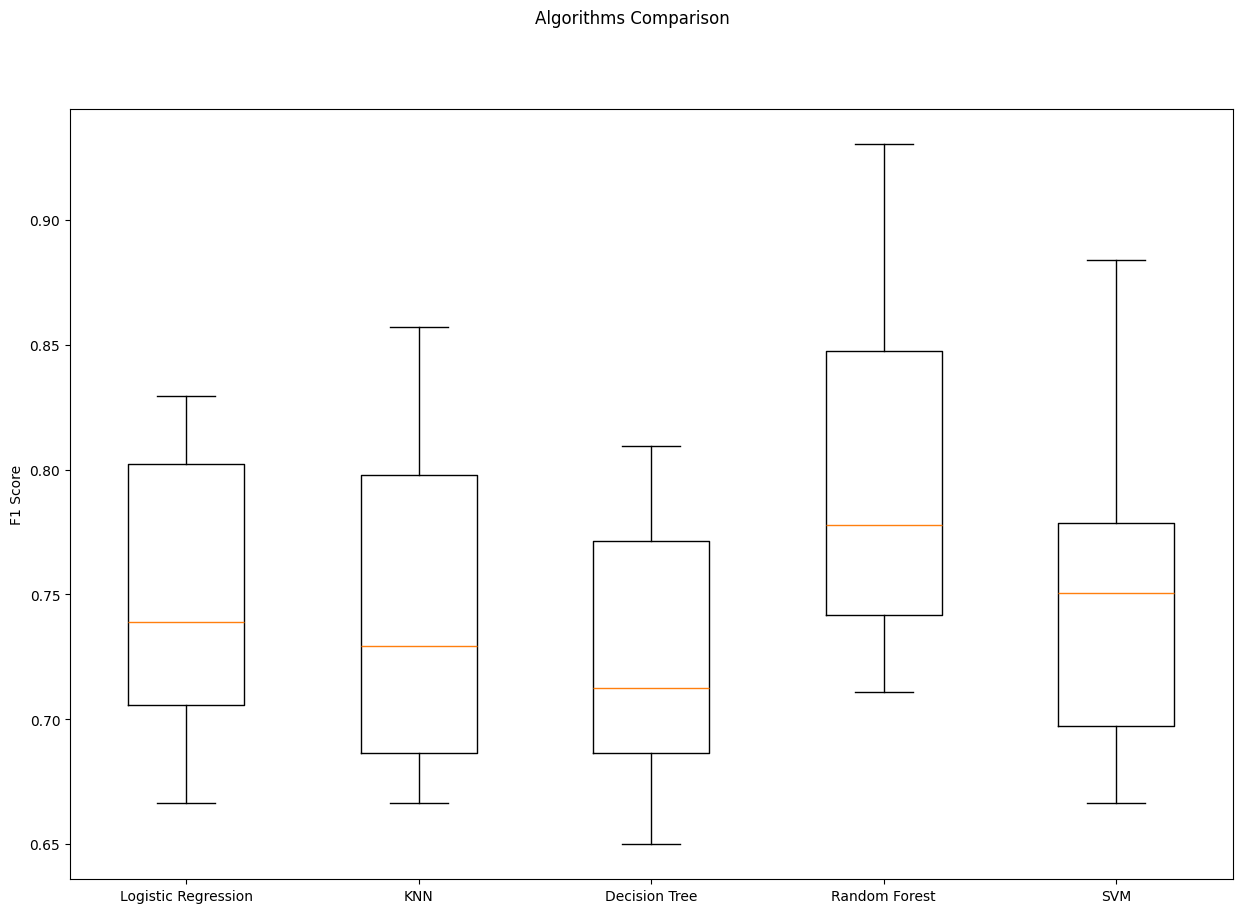

In [62]:
models = []
models.append(('Logistic Regression', LogisticRegression(random_state = 42)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier(random_state = 42)))
models.append(('Random Forest', RandomForestClassifier(random_state = 42)))
models.append(('SVM', SVC(gamma='auto', random_state = 42)))

# evaluate each model in turn

results = []
names = []

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
for name, model in models:
    
        kfold = KFold(n_splits = 10)
        model.fit(x_train, y_train)
        cv_results = cross_val_score(model, x_train, y_train, cv = 10, scoring= "f1")
        y_pred = model.predict(x_test)
        f1 = f1_score(y_test, y_pred)
        results.append(cv_results)
        names.append(name)
        print(name)
        print("F1 Score: ", f1)
        print("********")
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)

ax.set_ylabel("F1 Score")
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

